In [1]:
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import random

In [2]:
data_dir = Path('data')


## Loading Prepared data

In [3]:
ewing_df = pd.read_csv(data_dir / 'Ewing_cell_lines/Ewing_NT_cell_lines.csv', index_col=0)
train_Y_df = pd.read_csv(data_dir / 'mat4-CellO_train-ewing_genes.csv', index_col=0)

In [4]:
Z_df = pd.read_csv(data_dir / 'plierResult-cello_train/Z.csv')
Z_df = Z_df[Z_df.index.isin(ewing_df.columns)]
Z_mat = Z_df.values

In [5]:
# sorting columns according to Z
train_Y_df = train_Y_df[Z_df.index]
ewing_df = ewing_df[Z_df.index]

In [6]:
assert (train_Y_df.columns != ewing_df.columns).sum() == 0
assert (train_Y_df.columns != Z_df.index).sum() == 0

### Normalization

In [7]:
# computing normalization values on train dataset
per_gene_mean = train_Y_df.mean().values
per_gene_std = train_Y_df.std().values

train_y_vectors = (train_Y_df.values - per_gene_mean) / per_gene_std
test_y_vectors = (ewing_df.values - per_gene_mean) / per_gene_std

### Using regression to find the B that will produce vectors close to test Y

In [8]:
from numpy.linalg import inv

In [9]:
X = Z_mat

# linear least squares
# check this for more details: https://machinelearningmastery.com/solve-linear-regression-using-linear-algebra/
b_test = inv(X.T.dot(X)).dot(X.T).dot(test_y_vectors.T)
b_test.shape

(512, 11)

In [10]:
y_test_hat = Z_mat.dot(b_test).transpose()

In [11]:
y_test_hat.shape

(11, 5775)

In [12]:
def pearson_dists(vectors_a, vectors_b):
    vectors_pairs = zip(vectors_a, vectors_b)
    return [scipy.spatial.distance.correlation(a, b) for a, b in vectors_pairs]

In [13]:
y2y_hat_dists = pearson_dists(test_y_vectors, y_test_hat)
y2y_random_dists = pearson_dists(
    test_y_vectors, 
    random.sample(test_y_vectors.tolist(), len(test_y_vectors))
)

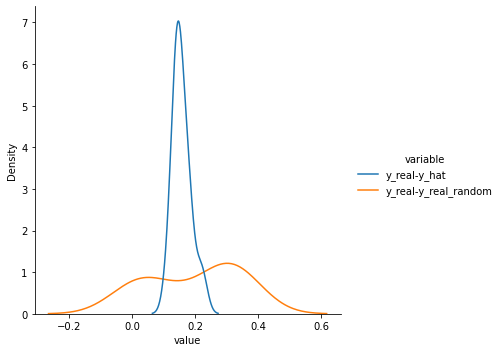

In [14]:
dists_df = pd.DataFrame({
    'y_real-y_hat': y2y_hat_dists,
    'y_real-y_real_random': y2y_random_dists
})

sns.displot(
    data=pd.melt(dists_df, value_vars=dists_df.columns), 
    x='value', hue='variable', kind='kde')

## Validating embeddings

In [15]:
import sys
sys.path.append('../../onto_lib')

In [16]:
import sys
!{sys.executable} -m pip install anndata
!{sys.executable} -m pip install scanpy

In [17]:
from anndata import AnnData
import json
import scanpy as sc
import general_ontology_tools as got

Unable to import pygraphviz. Visualization is disabled.
Loading ontology from C:\Users\julia\Desktop\cancer-normal-transformer-main\obo\DOID.17-01-30.obo ...
Loading ontology from C:\Users\julia\Desktop\cancer-normal-transformer-main\obo\UBERON.17-01-30.obo ...
Loading ontology from C:\Users\julia\Desktop\cancer-normal-transformer-main\obo\CL.18-11-13.obo ...
Loading ontology from C:\Users\julia\Desktop\cancer-normal-transformer-main\obo\CVCL.17-01-30.obo ...
Loading ontology from C:\Users\julia\Desktop\cancer-normal-transformer-main\obo\EFO.17-01-30.obo ...


In [18]:
with open(data_dir / 'CellO_data/bulk_RNA_seq_training_set/bulk_labels.json', 'r') as f:
    sample2cell_types_ids = json.load(f)

In [19]:
sample2types = {
    sample: list(map(got.get_term_name, types_ids))
    for sample, types_ids in sample2cell_types_ids.items()
}

In [20]:
test_b_vectors = b_test.T
test_samples = ewing_df.index.values

In [21]:
B_df = pd.read_csv(data_dir / 'plierResult-cello_train/B.csv').transpose()
B_df.shape

(3609, 512)

In [22]:
b_test_df = pd.DataFrame(test_b_vectors)
b_test_df.index = test_samples
b_test_df.columns = B_df.columns
b_test_df.shape

(11, 512)

In [23]:
B_full = pd.concat([B_df, b_test_df])
B_full.shape

(3620, 512)

In [24]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
types_per_b_samples = B_df.index.map(sample2types).values

train_dummies = pd.DataFrame(mlb.fit_transform(types_per_b_samples), columns=mlb.classes_, index=B_df.index)

In [25]:
types_dummies = pd.concat([train_dummies, b_test_df])[train_dummies.columns]

In [26]:
test_mask = B_full.index.isin(test_samples)
train_mask = ~test_mask

In [27]:
ad = AnnData(B_full)

In [28]:
sc.pp.neighbors(ad, use_rep='X', n_neighbors=30)
sc.tl.umap(ad)

In [29]:
def as_category(data):
    return pd.Series(data).astype('category').values

# Add cell type annotations to AnnData object
for ct in types_dummies.columns:
    dummy_mask = types_dummies[ct] == 1
    ct_values = types_dummies[ct].copy()
    ct_values[~dummy_mask] = None
    ct_values[dummy_mask & train_mask] = 'train'
    ct_values[test_mask] = 'test'
    
    ad.obs[ct] = as_category(ct_values)    
    ad.obs[ct + ' - train'] = as_category(dummy_mask & ~test_mask)

ad.obs['test_sample'] = as_category(test_mask)

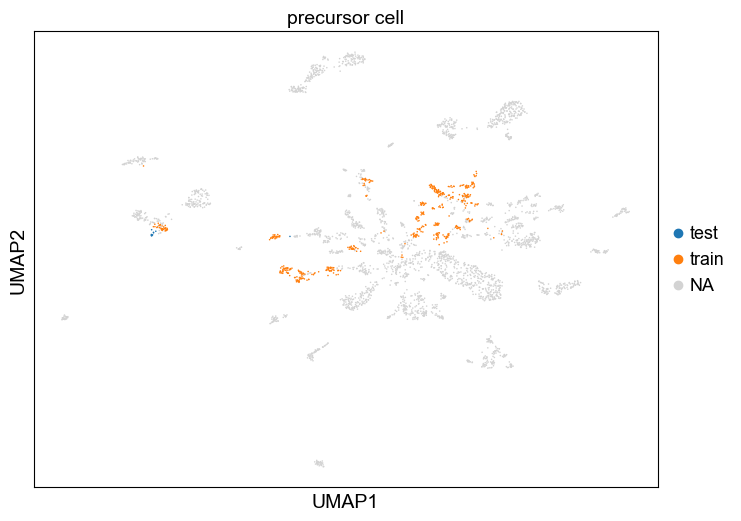

In [30]:
sc.set_figure_params(dpi=100)
plt.rcParams['figure.figsize'] = (8, 6)

for ctype in ['precursor cell']:
    sc.pl.umap(ad, color=ctype, size=5, groups=['test', 'train'])

## Classification

In [31]:
from sklearn.metrics import precision_score, recall_score

def get_pearson_dists(vectors_a, vectors_b):
    vectors_pairs = zip(vectors_a, vectors_b)
    return [scipy.spatial.distance.correlation(a, b) for a, b in vectors_pairs]

def get_pearson_dists_mat(vectors_a, vectors_b):
    return np.array([
        # repeat the A vector for each B vector
        get_pearson_dists(np.array(vector_a[np.newaxis, :]).repeat(len(vectors_b), axis=0), vectors_b)
        for vector_a in vectors_a
    ])

In [32]:
B_mat = B_df.values
B_mat.shape

(3609, 512)

In [33]:
import numpy as np
train_samples = train_Y_df.index.values

In [34]:
pearson_dists = get_pearson_dists_mat(B_mat, b_test.T)
pearson_dists.shape

(3609, 11)

In [35]:
# distances is a n_test X n_train matrix
# with columns for test items and rows for train items
dists_df = pd.DataFrame(pearson_dists)
dists_df.columns = test_samples
dists_df.index = train_samples

In [36]:
dists_df

,SRX1025875,SRX1025870,SRX1025865,SRX4587813,SRX1025860,SRX4587810,SRX4587809,SRX4587814,SRX4587812,SRX4587811,SRX3183024
SRX890545,1.123341,1.093080,1.149312,1.176287,1.130003,1.162682,1.179348,1.172930,1.176636,1.174408,1.153624
SRX1067711,1.095372,1.070512,1.092030,1.146400,1.091306,1.145884,1.151763,1.151244,1.151614,1.149509,1.162105
SRX1067710,1.092076,1.068337,1.071123,1.117138,1.075141,1.121766,1.123312,1.127038,1.127990,1.127672,1.134322
SRX762971,1.189891,1.112461,1.152034,1.275148,1.137693,1.302435,1.271560,1.293856,1.280613,1.295817,1.232885
SRX762970,1.168876,1.119433,1.144632,1.230069,1.148199,1.257260,1.230887,1.249439,1.237513,1.251924,1.192815
...,...,...,...,...,...,...,...,...,...,...,...
SRX3399308,1.161585,1.160889,1.164010,1.175520,1.164991,1.155323,1.172775,1.173294,1.173528,1.166850,1.002303
SRX3399309,1.153807,1.136562,1.158399,1.142142,1.166722,1.135918,1.137730,1.144402,1.139293,1.139152,1.000138
SRX3399310,1.128456,1.138202,1.147428,1.123640,1.136540,1.098468,1.118481,1.116609,1.120599,1.113357,0.982749
SRX3399311,1.190447,1.191499,1.198184,1.168041,1.187077,1.159714,1.172222,1.173133,1.170796,1.171192,1.038376


In [37]:
test_sample2closest_train = {
    # get the column for current test sample and find the index of raw the closest value
    sample_id: dists_df[sample_id].sort_values().index[:10]
    for sample_id in test_samples
}


In [38]:
cell_types_y_predicted = pd.DataFrame([
    types_dummies.loc[test_sample2closest_train[test_id]].sum()
    for test_id in test_samples
])


In [39]:
import general_ontology_tools as got
import json
import pandas as pd
import math

with open(data_dir / 'CellO_data/bulk_RNA_seq_training_set/bulk_labels.json', 'r') as f:
    sample2cell_types_ids = json.load(f)

def calculate_idf(n_occourences,len_df):
    idf = math.log(len_df/n_occourences,10)
    return idf    

sample2types = {
    sample: list(map(got.get_term_name, types_ids))
    for sample, types_ids in sample2cell_types_ids.items()
}


IDF_df = pd.DataFrame.from_dict(sample2types,orient='index')
IDF_df = IDF_df.transpose()



# calculate IDF
# create list of names
counts = pd.DataFrame( columns=["cell_type","occourences","IDF"])
onto_list = []
for col in IDF_df:
    column = IDF_df[col]
    for i in column:
        if(i not in onto_list and i != None):
            onto_list += [i]
            

for item in onto_list:
    count = 0
    for col in IDF_df:
        column = IDF_df[col]
        if(item in column.unique()):
            count += 1
    idf = calculate_idf(count,len(IDF_df.columns))
    df_temp = pd.DataFrame([[item,count,idf]],columns=["cell_type","occourences","IDF"])    
    counts = counts.append(df_temp, ignore_index=True)
print(counts)



                                     cell_type occourences       IDF
0                                         cell        4293  0.000000
1                         enteroendocrine cell         195  1.342726
2                                  animal cell        4284  0.000911
3                               endocrine cell         210  1.310542
4                              eukaryotic cell        4293  0.000000
..                                         ...         ...       ...
312  neuron associated cell (sensu Vertebrata)           1  3.632761
313                                Merkel cell           1  3.632761
314                       epidermal melanocyte           1  3.632761
315                      epithelial melanocyte           1  3.632761
316                         melanocyte of skin           1  3.632761

[317 rows x 3 columns]


In [40]:
def get_idf(cell_type,df):
    index = df.loc[df["cell_type"] == cell_type]
    return index["IDF"].item()

In [41]:
#get TF (assuming each label occours once per sample)
def get_TF(df):
    tfs = pd.DataFrame( columns=["cell_type","TF"])
    labels = []
    for index,item in df.iteritems():
        TF = 1/len(df)
        df_temp = pd.DataFrame([[index,TF]],columns=["cell_type","TF"])
        tfs = tfs.append(df_temp,ignore_index=True)
   
    return tfs


In [43]:
#get labels for each sample 
cell_types_y_predicted_individual = cell_types_y_predicted
for index, row in cell_types_y_predicted_individual.iterrows():
   
    for index,item in row.iteritems():
        
        
        
        IDF = get_idf(index, counts)
        
        
        #print(label,TF_IDF)
        # normalize values with TF-IDF
        
        row[index] = row[index]*IDF
    
    cell_types_y_predicted_individual.loc[index] = row

    

In [56]:
for index, row in cell_types_y_predicted_individual.iterrows():
    row1 = row[row.iloc[:]> 0]
    row1.sort_values(ascending=False)
    print(row1)
    print("---------------------------------------------------")


animal cell                           0.008203
astrocyte                             6.653363
bone cell                             6.143404
connective tissue cell                6.303424
epidermal melanocyte                  3.632761
epithelial melanocyte                 3.632761
glial cell                            5.110026
glial cell (sensu Vertebrata)         5.110026
macroglial cell                       6.424198
melanocyte                            5.709219
melanocyte of skin                    3.632761
muscle precursor cell                 2.678518
myoblast                              2.678518
neural cell                           4.302311
neuron associated cell                5.094787
non-terminally differentiated cell    9.996462
osteoblast                            8.565597
pigment cell                          5.709219
precursor cell                        4.283933
somatic cell                          0.198711
stuff accumulating cell               2.672191
Name: 0, dtyp

In [50]:
# apply TF-IDF for all samples as one

labels = cell_types_y_predicted.sum()

for index,item in labels.iteritems():
    IDF = get_idf(index, counts)
        
        
    #print(label,TF_IDF)
    # normalize values with TF-IDF
        
    labels[index] = labels[index]*IDF


In [58]:

labels1 = labels[labels.iloc[:]> 0]
labels1 = labels1.sort_values(ascending=False)
print(labels1)

non-terminally differentiated cell           143.941982
osteoblast                                   133.977919
connective tissue cell                       102.908795
bone cell                                     92.371299
radial glial cell                             81.446193
glial cell                                    64.278610
glial cell (sensu Vertebrata)                 64.278610
neuron associated cell                        63.992035
precursor cell                                58.382052
neural cell                                   54.796024
astrocyte                                     39.151408
macroglial cell                               37.312163
muscle precursor cell                         28.602608
myoblast                                      28.602608
pigment cell                                  27.716031
melanocyte                                    27.716031
epidermal melanocyte                          20.462473
epithelial melanocyte                         20